<a href="https://colab.research.google.com/github/jesusmlb/Reviews_analysis-NLP-/blob/main/Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emoji

In [ ]:
!pip install cleantext

In [ ]:
!pip install pyLDAvis==2.1.2

In [39]:
# Data manipulation and analysis
import pandas as pd 
import re 
import string 
import emoji
from cleantext import clean 
import joblib

# Libraries for Natural language processing (NLP)
import nltk 
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer

# Topic modeling and semantic analysis in Python

from gensim.test.utils import common_corpus, common_dictionary
from gensim.models import HdpModel
from gensim.corpora.dictionary import Dictionary
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

# Warning displayed
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [40]:
# Tokenize the reviews using NLTK
nltk.download('punkt')
# Remove stop words using NLTK
nltk.download('stopwords')
# Lemmatizer our words using NLTK
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [41]:
#Let's load our data from Airbnb
reviews_df = pd.read_csv('//content/reviewsairbnb.csv')
reviews_df.head()

,Unnamed: 0,reviews
0,0,Very attentive and the stay is in perfect cond...
1,1,"Very nice stay in the house, a very nice and p..."
2,2,Well-located inn. Clean and comfortable
3,3,The description is very accurate to what is on...
4,4,"Please return the money, as the house was not ..."


In [42]:
# Drop Null values in DataFrame
reviews_df.dropna(inplace=True)

In [43]:
# Use regex to clean text from punctuation
regex = re.compile('[%s]' % re.escape(string.punctuation))

# Remove punctuation from review column
reviews_df['clean_text'] = reviews_df['reviews'].apply(lambda x: regex.sub('', x))

In [44]:
# Define function to remove emojis from text
def remove_emojis(text):
    no_emoji = emoji.replace_emoji(text, replace='[Unsupported emoji]')
    return no_emoji.replace('[Unsupported emoji]', ' ')

# Remove emojis from review column
reviews_df['clean_text'] = reviews_df['clean_text'].apply(remove_emojis)

In [45]:
# Have a look to new column
reviews_df.head()

,Unnamed: 0,reviews,clean_text
0,0,Very attentive and the stay is in perfect cond...,Very attentive and the stay is in perfect cond...
1,1,"Very nice stay in the house, a very nice and p...",Very nice stay in the house a very nice and pl...
2,2,Well-located inn. Clean and comfortable,Welllocated inn Clean and comfortable
3,3,The description is very accurate to what is on...,The description is very accurate to what is on...
4,4,"Please return the money, as the house was not ...",Please return the money as the house was not a...


In [46]:
# Tokenize the reviews using NLTK
reviews_df['tokens'] = reviews_df['clean_text'].apply(nltk.word_tokenize)

In [47]:
# Load the standard English stop words from NLTK
stop_words = set(stopwords.words('english'))

# Add "br" to the set of stop words
stop_words.add('br')

# Changing datatype of stop_words from 'set' to 'list'
stop_words = list(stop_words)

# Function to tokenize a review
def tokenize_review(review):
    tokens = nltk.word_tokenize(review)
    return tokens

reviews_df['tokens'] = reviews_df['tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words])

In [48]:
# Review differences between before and after tokenize words
reviews_df.head()

,Unnamed: 0,reviews,clean_text,tokens
0,0,Very attentive and the stay is in perfect cond...,Very attentive and the stay is in perfect cond...,"[attentive, stay, perfect, condition]"
1,1,"Very nice stay in the house, a very nice and p...",Very nice stay in the house a very nice and pl...,"[nice, stay, house, nice, pleasant, spacebrLik..."
2,2,Well-located inn. Clean and comfortable,Welllocated inn Clean and comfortable,"[Welllocated, inn, Clean, comfortable]"
3,3,The description is very accurate to what is on...,The description is very accurate to what is on...,"[description, accurate, arrive, Everything, co..."
4,4,"Please return the money, as the house was not ...",Please return the money as the house was not a...,"[Please, return, money, house, available, host..."


In [49]:
# Let's create a columns with the numbers of words per reviews
reviews_df['word_count'] = reviews_df['clean_text'].apply(lambda x: len(x.split()))

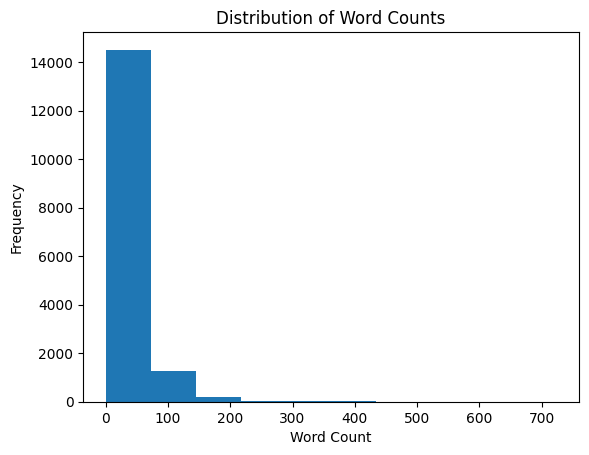

In [50]:
# create histogram of word counts
plt.hist(reviews_df['word_count'], bins=10)

# set labels and title
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts')

# show the plot
plt.show()

As we can notice, most of our reviews are between 0-100 but it is too wide to know the mean most common numbers of words left by people. For this purpose, let's shrink the reviews that have 100 or fewer.

In [51]:
short_reviews = reviews_df.loc[reviews_df['word_count'] < 100]

In [52]:
short_reviews['word_count'].describe()

count    15303.000000
mean        28.840227
std         21.460417
min          0.000000
25%         12.000000
50%         24.000000
75%         41.000000
max         99.000000
Name: word_count, dtype: float64

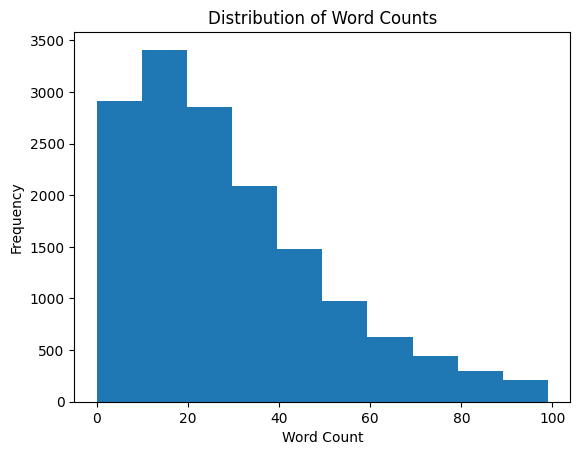

In [53]:
# Create a histogram of word counts with fewer words
plt.hist(short_reviews['word_count'], bins=10)

# set labels and title
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts')

# show the plot
plt.show()

### With a range of 0-100 words, we can see better that our reviews have between 15-20 words per person.

### Let's plot out the word cloud to observe our common words from a global perspective

3118727


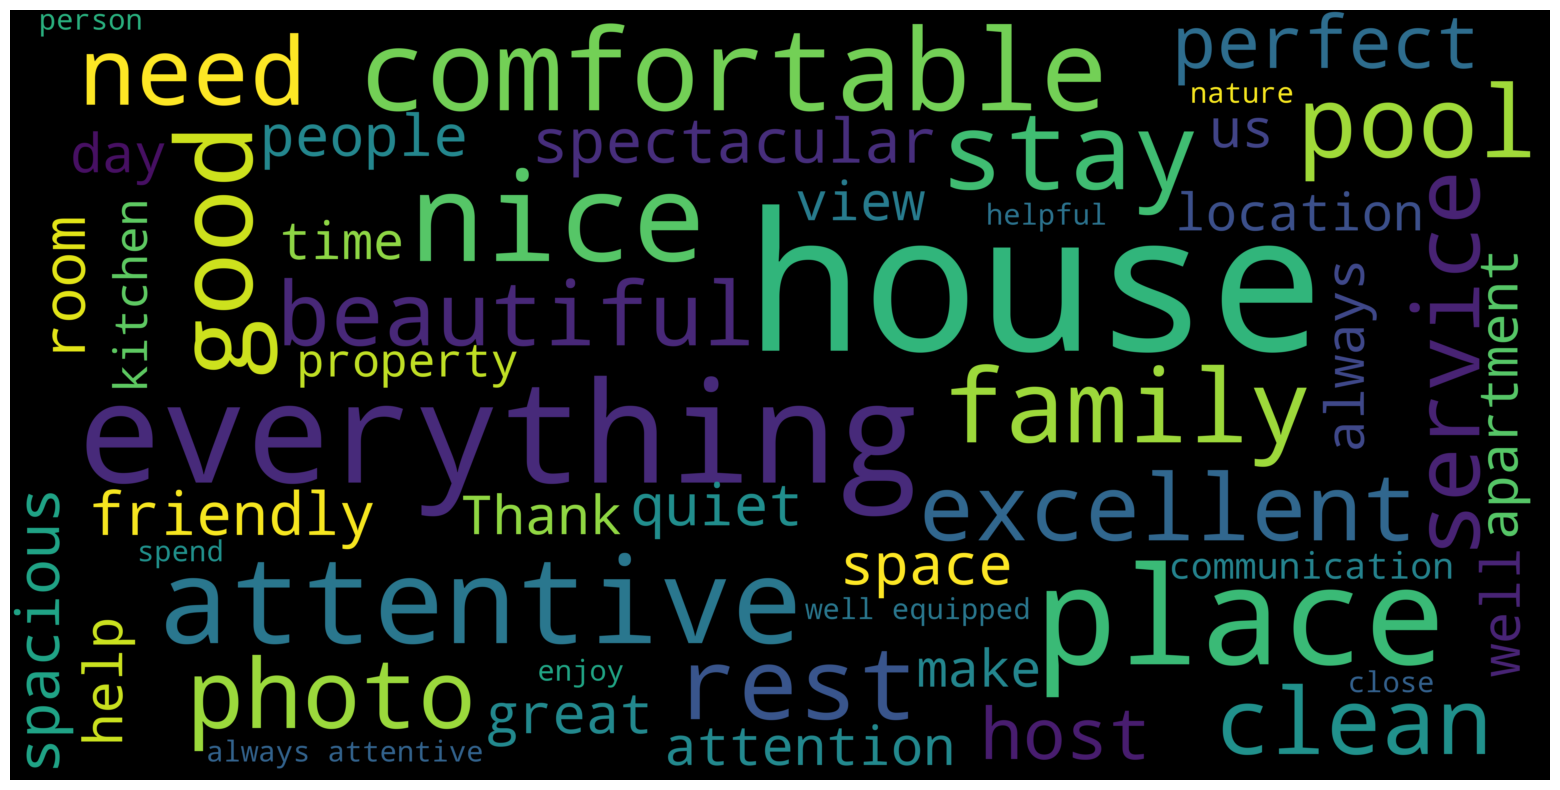

In [54]:
word_cloud_text = ''.join(reviews_df.clean_text)
print(len(word_cloud_text))

wordcloud = WordCloud(
    max_font_size=100,
    max_words=50,
    background_color="black",
    scale=10,
    width=800,
    height=400
).generate(word_cloud_text)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### After counting and visualizing our words. Let's see our top 10 words

In [55]:
# Let's lemmatizer our words using NLTK
lemmatizer = WordNetLemmatizer()
lemmatizer = WordNetLemmatizer()
reviews_df['lemmatized_review'] = reviews_df['clean_text'].apply(lambda x: nltk.word_tokenize(x.lower()))
reviews_df['lemmatized_review'] = reviews_df['lemmatized_review'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x if word not in stop_words])

In [56]:
# Let's pull it out of our reviews
lemmatized_tokens = reviews_df['lemmatized_review']
lemmatized_list = [] # Built a list so it can be an input for our Counter function
for i in lemmatized_tokens:
  lemmatized_list += i

In [57]:
# Count the frequency of each token
token_counts = Counter(lemmatized_list)

# Get the top 10 most frequent tokens
top_tokens = token_counts.most_common(10)

# Sort the top tokens by frequency in descending order
top_tokens = sorted(top_tokens, key=lambda x: x[1], reverse=False)

tokens, counts = zip(*top_tokens)

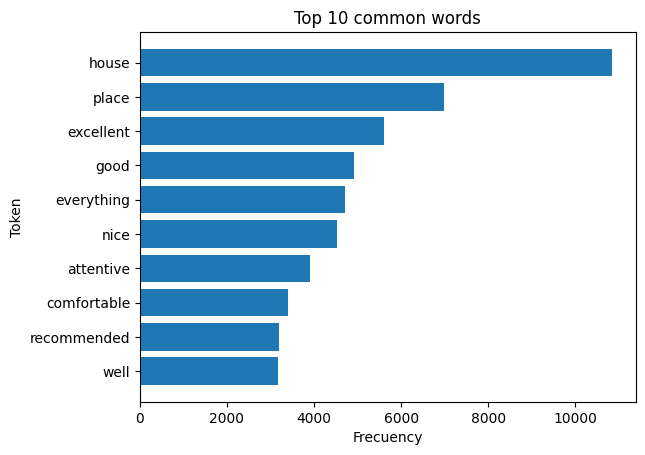

In [58]:
# Visualize the top 10 tokens and their frequencies using a bar chart
plt.barh(tokens, counts)
plt.xlabel('Frecuency')
plt.ylabel('Token')
plt.title('Top 10 common words')
plt.show()

### Excellent, good, and nice are in our top 10. But what are describing these adjectives? Let's find out words after those ones

In [59]:
# Let's take the words out of our review before lemmatized
all_words = reviews_df['tokens']
all_words_list = [] # Built a list so it can be an input for our Counter function
for i in all_words:
  all_words_list += i

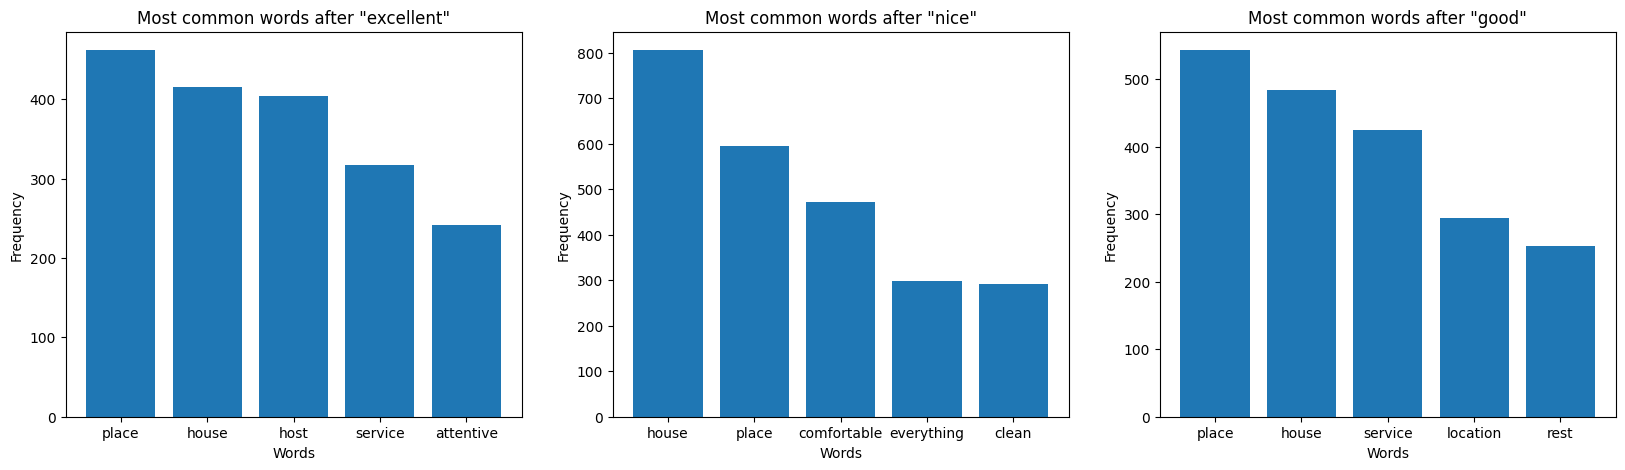

In [60]:
# Words to be excluded while looking after a keyword
exclude_words = ['good', 'nice', 'well', 'excellent']

# Function to extract specific words and their following words, excluding stop words and specific words to exclude
def extract_word_and_after(tokens, specific_word, num_words=3):
    word_indices = [i for i, token in enumerate(tokens) if token == specific_word]
    word_list = []
    for i in word_indices:
        if i < len(tokens)-(num_words+1):
            word_list.extend(tokens[i+1:i+num_words+1])
        else:
            word_list.extend(tokens[i+1:])
    # Filter out stop words and specific words to exclude from the word list
    word_list = [word.lower() for word in word_list if word.lower() not in stop_words and word.lower() not in exclude_words]
    return word_list

# Extract the words that follow the specified keywords in the list of words, excluding stop words and the specified words to exclude
keywords = ['excellent', 'nice', 'good']
word_counts = {}
for keyword in keywords:
    words_after_keyword = extract_word_and_after(all_words_list, keyword)
    keyword_counts = Counter(words_after_keyword)
    # Extract the 2 most common non-stopwords that follow the keyword
    most_common_words = dict(keyword_counts.most_common(5))
    # Store the resulting dictionary of word counts in the word_counts dictionary, with the keyword as the key
    word_counts[keyword] = most_common_words

# Plot the bar charts for each keyword
fig, axs = plt.subplots(1, len(keywords), figsize=(20, 5))
for i, keyword in enumerate(keywords):
    axs[i].bar(word_counts[keyword].keys(), word_counts[keyword].values())
    axs[i].set_xlabel('Words')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(f'Most common words after "{keyword}"')

# Show the plot
plt.show()

### Ploting our afterwords we can observe that words like place/house, host, services, and location are common. We can conclude people are describing in a positive way their stay.

## But how about our bad adjectives? Let's have a look at this

Let's try these words : 

* Bad
* Terrible
* Poor

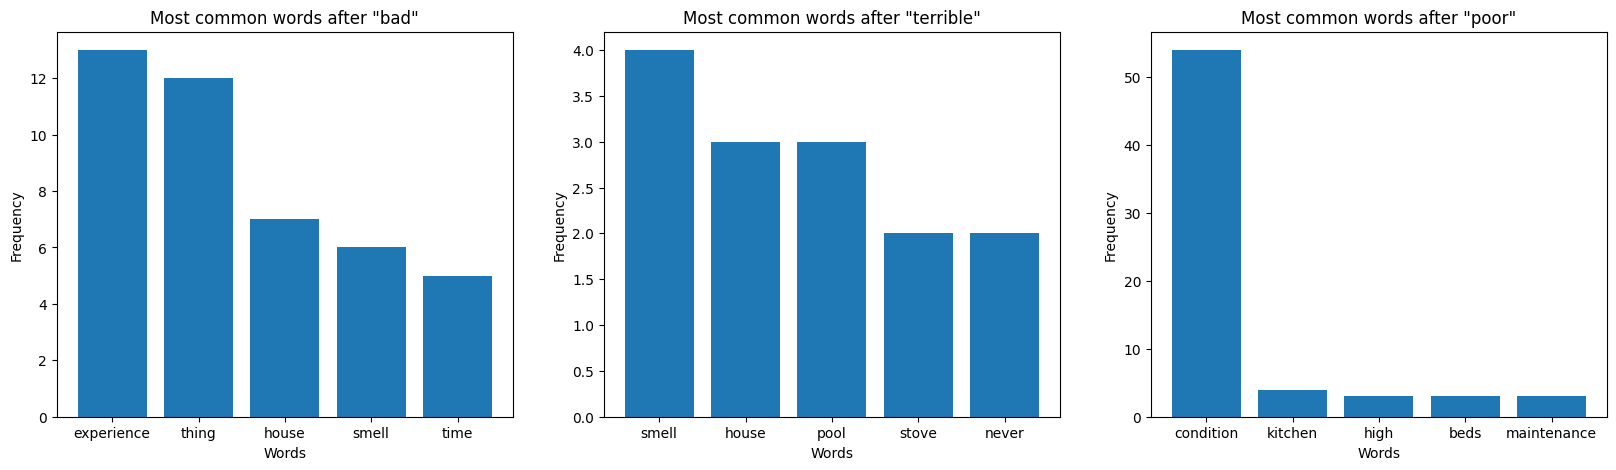

In [61]:
# Words to be excluded while looking after keyword
exclude_words = ['good', 'nice', 'well', 'excellent']

# Function to extract specific words and their following words, excluding stop words and specific words to exclude
def extract_word_and_after(tokens, specific_word, num_words=3):
    word_indices = [i for i, token in enumerate(tokens) if token == specific_word]
    word_list = []
    for i in word_indices:
        if i < len(tokens)-(num_words+1):
            word_list.extend(tokens[i+1:i+num_words+1])
        else:
            word_list.extend(tokens[i+1:])
    # Filter out stop words and specific words to exclude from the word list
    word_list = [word.lower() for word in word_list if word.lower() not in stop_words and word.lower() not in exclude_words]
    return word_list

# Extract the words that follow the specified keywords in the list of words, excluding stop words and the specified words to exclude
keywords = ['bad', 'terrible', 'poor']
word_counts = {}
for keyword in keywords:
    words_after_keyword = extract_word_and_after(all_words_list, keyword)
    keyword_counts = Counter(words_after_keyword)
    # Extract the 2 most common non-stopwords that follow the keyword
    most_common_words = dict(keyword_counts.most_common(5))
    # Store the resulting dictionary of word counts in the word_counts dictionary, with the keyword as the key
    word_counts[keyword] = most_common_words

# Plot the bar charts for each keyword
fig, axs = plt.subplots(1, len(keywords), figsize=(20, 5))
for i, keyword in enumerate(keywords):
    axs[i].bar(word_counts[keyword].keys(), word_counts[keyword].values())
    axs[i].set_xlabel('Words')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(f'Most common words after "{keyword}"')

# Show the plot
plt.show()

### As we can see bad reviews are not that common in this dataset. But we did get some conclusions about it. For example:

* 'Smell' is one of the common things that people are complaining
* 'House' as well. Otherwise, this is common with good adjectives and bad ones
* 'Pool' wasn't that common but it is a good insight for a host that has one and should take care of these reviews
* 'Poor' was the negative keyword with more common words after, as we can see condition was one of them. This gave us a good point to start in those properties that don't have the standard condition to have a guest. This will help hosts to take action on their listings.

### After getting these insights about common words and what was described, we would like to apply Latent Dirichlet Allocation (LDA) and finds topics for our reviews. It's interesting and also helpful to gain perspective from another resource and compare both analyses.


In [62]:
# Create a dictionary from the lemmatized reviews
dictionary = corpora.Dictionary(reviews_df['lemmatized_review'])

# Create a bag-of-words corpus from the reviews
corpus = [dictionary.doc2bow(review) for review in reviews_df['lemmatized_review']]

corpus = [doc for doc in corpus if len(doc)>1]

In [63]:
# Apply Latent Dirichlet Allocation (LDA) to the bag-of-words representation to extract topics
lda = gensim.models.ldamodel.LdaModel(num_topics=10, 
                                corpus=corpus, 
                                random_state=42, 
                                id2word=dictionary,
                                alpha='auto', 
                                per_word_topics=True)

In [64]:
lda.save("ldamod")

In [65]:
text = []
for i in reviews_df['lemmatized_review']:
  text.append(i)

In [66]:
# Compute Perplexity
print('\nPerplexity: ', lda.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, corpus=corpus, texts=text, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.05681665134813

Coherence Score:  0.4677259914131934


In [67]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda,  corpus, dictionary, mds='mmds')  

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [69]:
# Plot topics and words in it
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.027215 -0.166558       1        1  18.080054
0     -0.028513 -0.025360       2        1  13.632018
1     -0.019276  0.078750       3        1  13.078835
7     -0.112814  0.150240       4        1  11.298365
3      0.137047 -0.131199       5        1   9.782389
6      0.107907  0.003280       6        1   8.993504
9      0.003989  0.206836       7        1   8.990201
8     -0.083188 -0.174351       8        1   7.270041
4     -0.224884 -0.017758       9        1   4.834376
5      0.192518  0.076120      10        1   4.040217, topic_info=           Term         Freq        Total Category  logprob  loglift
95        thank  1200.000000  1200.000000  Default  30.0000  30.0000
24   everything  4959.000000  4959.000000  Default  29.0000  29.0000
47    excellent  5641.000000  5641.000000  Default  28.0000  28.0000
93         much  1145.000000  1145.000000  Default  27.0000  27.0000
72         well  3347.000000  3347.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
103       photo    79.319789  2067.448402  Topic10  -4.9864  -0.0517
83        place    88.270190  7102.566071  Topic10  -4.8795  -1.1789
3          stay    77.205251  3103.825921  Topic10  -5.0134  -0.4851
96            u    69.047741  2658.154960  Topic10  -5.1251  -0.4417
4      friendly    68.446253  1638.793134  Topic10  -5.1338   0.0332

[815 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
73        1  0.090925     10
73        2  0.052641     10
73        3  0.205778     10
73        4  0.019142     10
73        5  0.028713     10
...     ...       ...    ...
1697      6  0.945334  youre
1697      7  0.022508  youre
826       9  0.976241   zona
2257     10  0.953506      “
2258     10  0.955905      ”

[2403 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 8, 4, 7, 10, 9, 5, 6])